# Book Character Network Analysis

Consider “Les Miserables” dataset consisting of network coappearance of characters that occur in the same chapter of Victor Hugo’s novel “Les miserables” and where the weights of the edges correspond to the number of such coappearances.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import powerlaw
from networkx.algorithms import community
from community import community_louvain

1. Read `lesmis.gml` file and use NetworkX to display the corresponding network, suggest appropriate simple labelling of the nodes to maintain the readability of the network graph as clear as possible. Save the adjacency matrix of this graph in a separate file.

c:\Users\maxga\AppData\Local\Programs\Python\Python312\Lib\site-packages\networkx\drawing\nx_pylab.py:450: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  node_collection = ax.scatter(


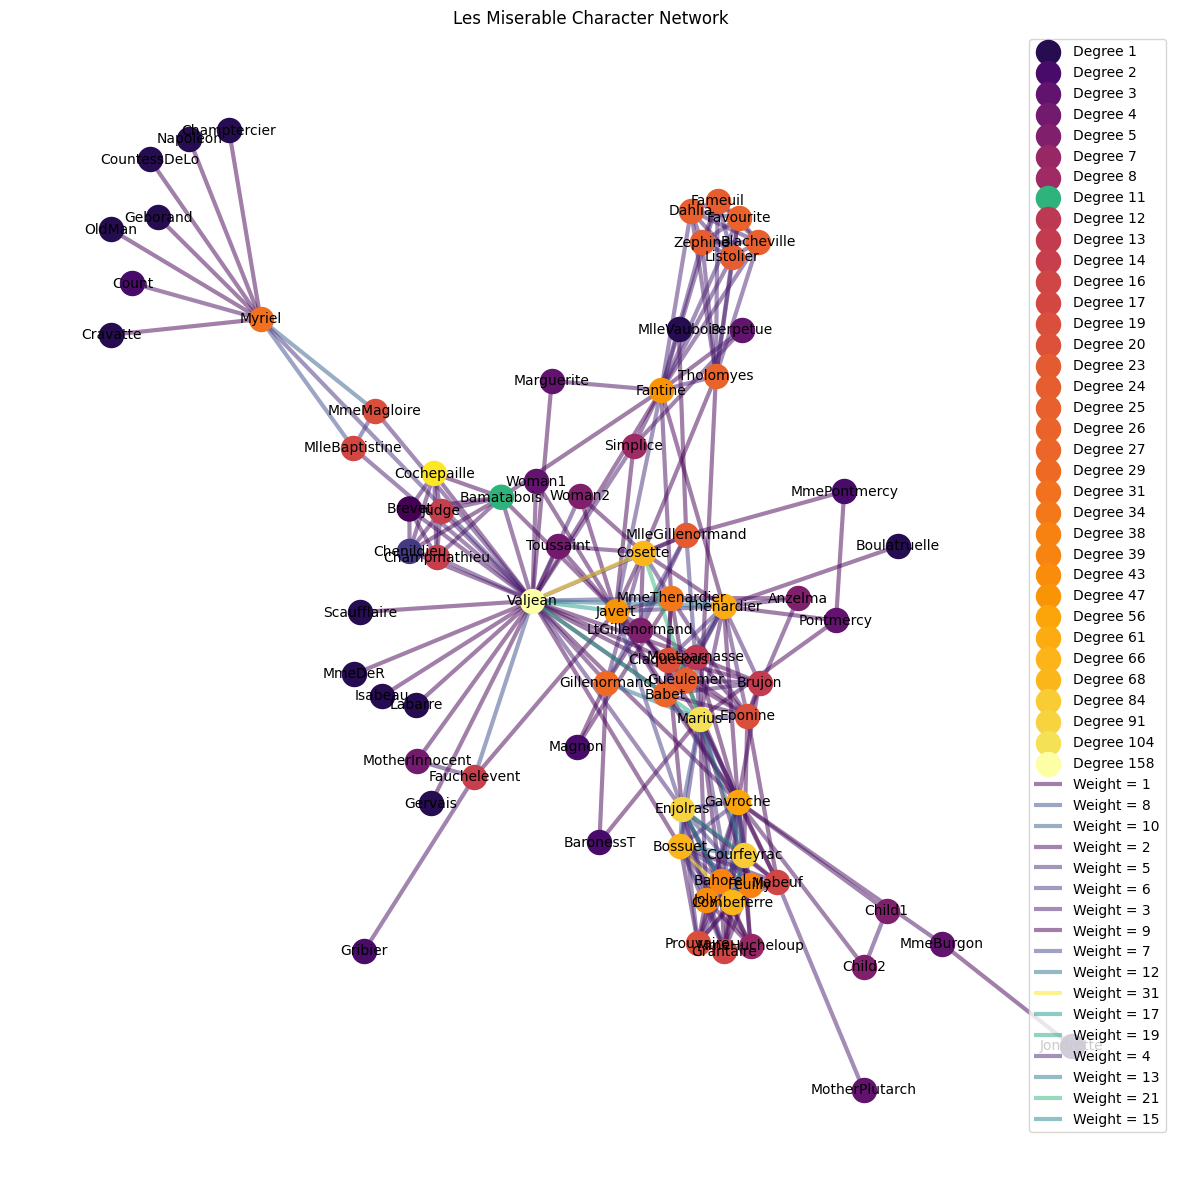

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


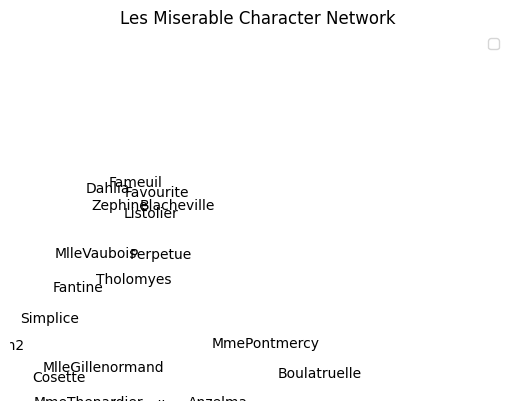

Adjacency matrix is saved to adjacency_matrix.txt


In [16]:
def read_network(file):
    # Read the graph from .gml file
    graph = nx.read_gml(file)
    return graph
# Define function which group nodes based on their degree
def classify_nodes(graph):
    node_degree = graph.degree(weight='value')
    degree_groups = {}
    for (node, degree) in node_degree:
        if degree not in degree_groups:
            degree_groups[degree] = []
        degree_groups[degree].append(node)
    # Sort the degree groups dictionary based on their degrees
    degree_groups = dict(sorted(degree_groups.items()))
    return degree_groups
# Define function which classify the edges into groups based on their weight
def classify_edges(graph):
    edge_weights = [d['value'] for _, _, d in graph.edges(data=True)]
    max_weight = max(edge_weights)
    min_weight = min(edge_weights)
    norm = plt.Normalize(vmin=min_weight, vmax=max_weight)
    colormap = plt.cm.viridis
    edge_colors = {weight: colormap(norm(weight)) for weight in edge_weights}
    edge_groups = {weight: [] for weight in edge_weights}
    for u, v, d in graph.edges(data=True):
        edge_weight = d['value']
        edge_groups[edge_weight].append((u, v, edge_colors[edge_weight]))
    return edge_groups
# Define function which draw the network in a easily readable way
def group_visualization(graph, node_groups, edge_groups, graph_title, group_name):
    # Define colormap for node colors
    colormap = plt.cm.inferno

    # Set edge thickness based on edge weight
    edge_width = classify_edges(graph)

    # Draw graph
    plt.figure(figsize=(15, 15))
    pos = nx.spring_layout(graph, seed=42)

    # Draw nodes with colors based on their degree
    max_degree = max(node_groups.keys())
    for key, node_list in node_groups.items():
        log_degree = np.log10(key + 1)  # Take the logarithm of the degree with a base of 10
        normalized_degree = log_degree / np.log10(max_degree + 1)  # Normalize degree to [0, 1] on a log scale
        node_color = colormap(normalized_degree)
        nx.draw_networkx_nodes(graph, pos, nodelist=node_list, node_color=node_color,
                           node_size=300, alpha=1, label=f"{group_name} {key}")


    # Draw edges with colors based on their weights
    for weight, edge_list in edge_groups.items():
        nx.draw_networkx_edges(graph, pos, edgelist=edge_list, width=3, edge_color=edge_list[0][2], alpha=0.5, label=f"Weight = {weight}")

    nx.draw_networkx_labels(graph, pos, font_size=10, font_color='black')
    plt.title(graph_title)
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
    plt.axis('off')
    plt.show()

    nx.draw_networkx_labels(graph, pos, font_size=10, font_color='black')
    plt.title(graph_title)
    plt.legend(loc='upper right', bbox_to_anchor=(1, 1))
    plt.axis('off')
    plt.show()

# Define the function for calculating the adjacency matrix of the graph
def adjacency_matrix(graph, file_name):
    nodes = sorted(graph.nodes())
    adj_matrix = np.zeros((len(nodes), len(nodes)))
    for u, v, d in graph.edges(data=True):
        u_idx = nodes.index(u)
        v_idx = nodes.index(v)
        weight = d['value']
        adj_matrix[u_idx][v_idx] = weight
    np.savetxt(file_name, adj_matrix, fmt='%d')
    print(f"Adjacency matrix is saved to {file_name}")
lesmis_graph = nx.read_gml('lesmis.gml')
degree_groups = classify_nodes(lesmis_graph)
edge_groups = classify_edges(lesmis_graph)
group_visualization(lesmis_graph, degree_groups, edge_groups, "Les Miserable Character Network", "Degree")
adjacency_matrix(lesmis_graph, "adjacency_matrix.txt")

2.  Write a script that uses NetworkX functions to calculate the diameter, global clustering coefficient, average distance in the graph, smallest and largest component.

In [3]:
def calculate_metrics(graph, to_print=True):
    diameter = nx.diameter(graph, weight='value')
    global_clustering_coefficient = nx.average_clustering(graph, weight='value')
    average_distance = nx.average_shortest_path_length(graph, weight='value')
    smallest_component = len(min(nx.connected_components(graph), key=len))
    largest_component = len(max(nx.connected_components(graph), key=len))
    if to_print == True:
        print(f"Diameter: {diameter}")
        print(f"Global Clustering Coefficient: {global_clustering_coefficient}")
        print(f"Average Distance: {average_distance}")
        print(f"Smallest Component: {smallest_component}")
        print(f"Largest Component: {largest_component}")
    return diameter, global_clustering_coefficient
_, _ = calculate_metrics(lesmis_graph)

Diameter: 14
Global Clustering Coefficient: 0.05502699314742024
Average Distance: 4.861244019138756
Smallest Component: 77
Largest Component: 77


3. Suggest a script that uses NetworkX functions to identify the nodes (characters) of the three highest degree centrality, three highest closeness centrality and three highest betweenness centrality.  

In [4]:
def calculate_centrality(graph):
    # Degree centrality
    node_degree = nx.degree(graph, weight='value')
    degree_centrality = {}
    num_nodes = len(graph)
    for (node, degree) in node_degree:
        node_dc = degree / (num_nodes - 1)
        degree_centrality[node] = node_dc
    closeness_centrality = nx.closeness_centrality(graph, distance='value')
    betweenness_centrality = nx.betweenness_centrality(graph, weight='value')
    return degree_centrality, closeness_centrality, betweenness_centrality
def top3_centrality(degree_centrality, closeness_centrality, betweenness_centrality):
    degree_top3 = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:3]
    closeness_top3 = sorted(closeness_centrality.items(), key=lambda x: x[1], reverse=True)[:3]
    betweenness_top3 = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:3]
    print(f"Top 3 Degree Centrality: {degree_top3}")
    print(f"Top 3 Closeness Centrality: {closeness_top3}")
    print(f"Top 3 Betweenness Centrality: {betweenness_top3}")
degree_centrality, closeness_centrality, betweenness_centrality = calculate_centrality(lesmis_graph)
top3_centrality(degree_centrality, closeness_centrality, betweenness_centrality)

Top 3 Degree Centrality: [('Valjean', 2.0789473684210527), ('Marius', 1.368421052631579), ('Enjolras', 1.1973684210526316)]
Top 3 Closeness Centrality: [('Gavroche', 0.3318777292576419), ('Valjean', 0.32340425531914896), ('Montparnasse', 0.3089430894308943)]
Top 3 Betweenness Centrality: [('Valjean', 0.45389967342598925), ('Gavroche', 0.28515261006050474), ('Javert', 0.1934002556897294)]


4. Write a script that plots the degree centrality distribution, closeness centrality distribution and betweenness centrality distribution.

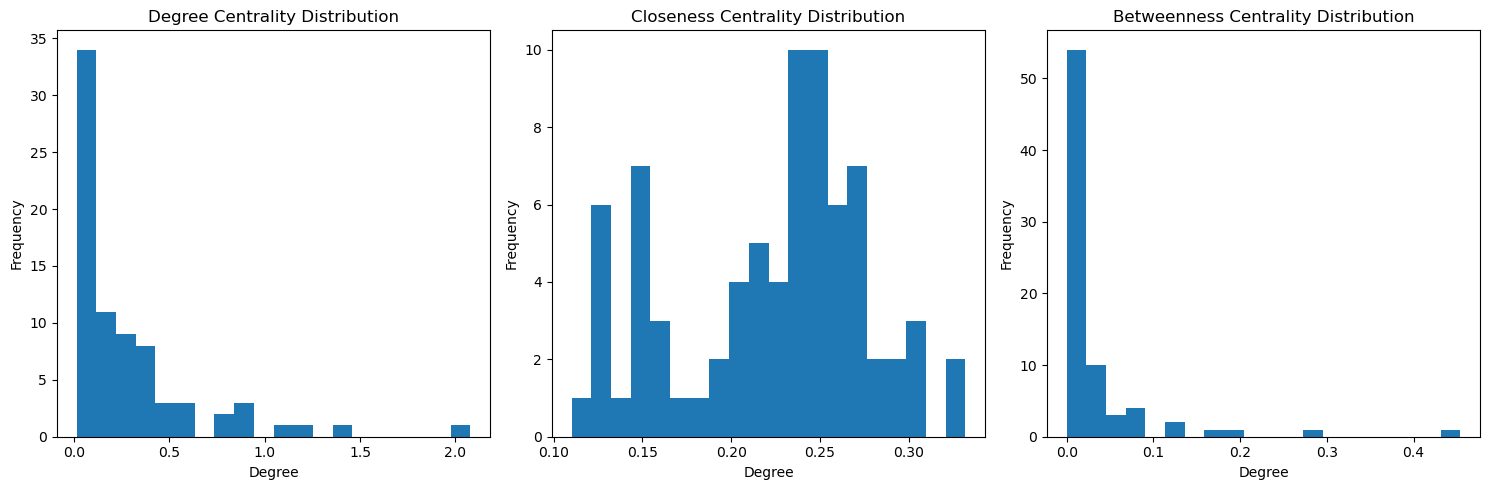

In [5]:
# Define function for changing centrality dictionaries to lists
def list_centrality(degree_centrality, closeness_centrality, betweenness_centrality):
    degree_list = list(degree_centrality.values())
    closeness_list = list(closeness_centrality.values())
    betweenness_list = list(betweenness_centrality.values())
    return degree_list, closeness_list, betweenness_list
# Define function for plot the centralities distributions
def centrality_histogram(degree, closeness, betweenness):
    # Change the centralities dictonaries obtained from input to list 
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    # Plot degree centrality distribution
    axs[0].hist(degree, bins=20)
    axs[0].set_title("Degree Centrality Distribution")
    axs[0].set_xlabel("Degree")
    axs[0].set_ylabel("Frequency")
    # Plot closeness centrality distribution
    axs[1].hist(closeness, bins=20)
    axs[1].set_title("Closeness Centrality Distribution")
    axs[1].set_xlabel("Degree")
    axs[1].set_ylabel("Frequency")
    # Plot betweenness centrality distribution
    axs[2].hist(betweenness, bins=20)
    axs[2].set_title("Betweenness Centrality Distribution")
    axs[2].set_xlabel("Degree")
    axs[2].set_ylabel("Frequency")
    plt.tight_layout()
    plt.show()
degree_list, closeness_list, betweenness_list = list_centrality(degree_centrality, closeness_centrality, betweenness_centrality)
centrality_histogram(degree_list, closeness_list, betweenness_list)

5. We want to test the extent to which the centrality distributions in 3) fit a power law distribution. You may inspire from the implementation in powerlaw · PyPI  of the power-law distribution, or can use alternative one of your choice. It is important to quantify the goodness of fit using p-value. Typically, when p-value is greater than 10%, we can state that power-law is a plausible fit to the (distribution) data. 

In [6]:
def fit_powerlaw(data):
    unique_data = []
    # Remove zero values from the data
    for x in data:
        if  x > 0:
            unique_data.append(x)
    # Check if the data list are empty
    if len(unique_data) == 0:
        return np.nan
    fit = powerlaw.Fit(unique_data, discrete=True)
    return fit.distribution_compare('power_law', 'lognormal_positive')[1]
def quantify_powerlaw(p_value, value_title, powerlaw_type):
    if p_value > 0.1:
        print(f"{value_title} fits the {powerlaw_type} distribution.")
    else:
        print(f"{value_title} does NOT fit the {powerlaw_type} distribution")
degree_p1 = fit_powerlaw(degree_list)
closeness_p1 = fit_powerlaw(closeness_list)
betweenness_p1 = fit_powerlaw(betweenness_list)
quantify_powerlaw(degree_p1, "Degree centrality", "powerlaw")
quantify_powerlaw(closeness_p1, "Closeness centrality", "powerlaw")
quantify_powerlaw(betweenness_p1, "Betweenness centrality", "powerlaw")

Calculating best minimal value for power law fit
C:\Users\Admin\miniconda3\envs\myenv\lib\site-packages\powerlaw.py:1146: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))


Degree centrality does NOT fit the powerlaw distribution
Closeness centrality does NOT fit the powerlaw distribution
Betweenness centrality does NOT fit the powerlaw distribution


C:\Users\Admin\miniconda3\envs\myenv\lib\site-packages\powerlaw.py:699: RuntimeWarning: invalid value encountered in divide
  (CDF_diff**2) /
C:\Users\Admin\miniconda3\envs\myenv\lib\site-packages\powerlaw.py:1146: RuntimeWarning: invalid value encountered in log
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
C:\Users\Admin\miniconda3\envs\myenv\lib\site-packages\powerlaw.py:1146: RuntimeWarning: divide by zero encountered in divide
  self.alpha = 1 + (self.n / sum(log(data / (self.xmin - .5))))
C:\Users\Admin\miniconda3\envs\myenv\lib\site-packages\powerlaw.py:699: RuntimeWarning: divide by zero encountered in divide
  (CDF_diff**2) /
Calculating best minimal value for power law fit
No valid fits found.
C:\Users\Admin\miniconda3\envs\myenv\lib\site-packages\powerlaw.py:698: RuntimeWarning: overflow encountered in double_scalars
  self.Asquare = sum((
Calculating best minimal value for power law fit
No valid fits found.


6. We want to use exponentially truncated power-law instead of power law distribution. Suggest a script that quantifies the goodness of fit for degree-centrality, closeness centrality and betweenness centrality distributions. 

In [7]:
def fit_exp_truncated_powerlaw(data):
    unique_data = []
    # Remove zero values from the data
    for x in data:
        if  x > 0:
            unique_data.append(x)
    # Check if the data list are empty
    if len(unique_data) == 0:
        return np.nan
    fit = powerlaw.Fit(unique_data, discrete=True)
    return fit.distribution_compare('truncated_power_law', 'exponential')[1]
degree_p2 = fit_exp_truncated_powerlaw(degree_list)
closeness_p2 = fit_exp_truncated_powerlaw(closeness_list)
betweenness_p2 = fit_exp_truncated_powerlaw(betweenness_list)
quantify_powerlaw(degree_p2, "Degree centrality", "exponentially truncated powerlaw")
quantify_powerlaw(closeness_p2, "Closeness centrality", "exponentially truncated powerlaw")
quantify_powerlaw(betweenness_p2, "Betweenness centrality", "exponentially truncated powerlaw")

Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Degree centrality fits the exponentially truncated powerlaw distribution.
Closeness centrality does NOT fit the exponentially truncated powerlaw distribution
Betweenness centrality fits the exponentially truncated powerlaw distribution.


7. We want to identify relevant communities from the network graph. For this purpose, use Louvain algorithm implementation in NetworkX to identify the main communities. Write a script that uses different color for each community and visualize the above graph with the detected communities. Use the appropriate function in NetworkX to compute the separation among the various communities and any other related quality measures. 

Communities {1: ['Myriel', 'Napoleon', 'MlleBaptistine', 'MmeMagloire', 'CountessDeLo', 'Geborand', 'Champtercier', 'Cravatte', 'Count', 'OldMan'], 2: ['Jondrette', 'MmeBurgon', 'Gavroche', 'Mabeuf', 'Enjolras', 'Combeferre', 'Prouvaire', 'Feuilly', 'Courfeyrac', 'Bahorel', 'Bossuet', 'Joly', 'Grantaire', 'MotherPlutarch', 'Child1', 'Child2', 'MmeHucheloup'], 3: ['Marguerite', 'Tholomyes', 'Listolier', 'Fameuil', 'Blacheville', 'Favourite', 'Dahlia', 'Zephine', 'Fantine'], 4: ['Labarre', 'Valjean', 'MmeDeR', 'Isabeau', 'Gervais', 'Cosette', 'Javert', 'Fauchelevent', 'Perpetue', 'Simplice', 'Scaufflaire', 'Woman1', 'Pontmercy', 'Woman2', 'MotherInnocent', 'Gribier', 'Gillenormand', 'Magnon', 'MlleGillenormand', 'MmePontmercy', 'MlleVaubois', 'LtGillenormand', 'Marius', 'BaronessT', 'Toussaint'], 5: ['Bamatabois', 'Judge', 'Champmathieu', 'Brevet', 'Chenildieu', 'Cochepaille'], 6: ['MmeThenardier', 'Thenardier', 'Boulatruelle', 'Eponine', 'Anzelma', 'Gueulemer', 'Babet', 'Claquesous', 'M

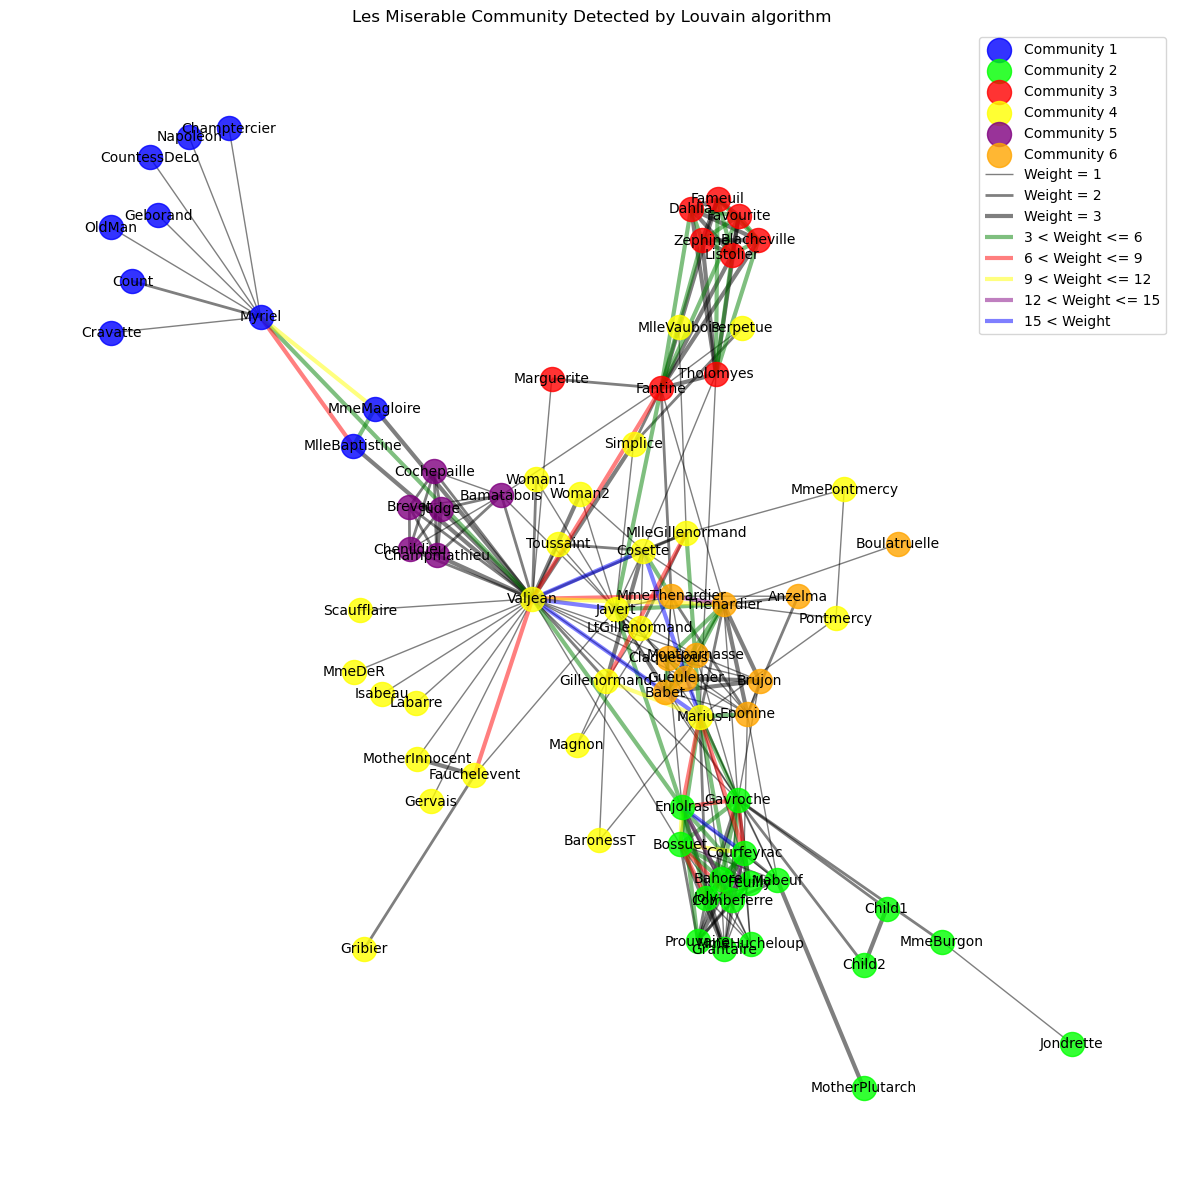

In [8]:
# Define function for partitioning network into community using Louvain algorithm
def louvain_community(graph):
    partition = community_louvain.best_partition(graph, weight='value')
    node_groups = {}
    for node, group in partition.items():
        if group + 1 not in node_groups:
            node_groups[group + 1] = []
        node_groups[group + 1].append(node)
    node_groups = dict(sorted(node_groups.items()))
    print(f"Communities {node_groups}")
    return node_groups
louvain_communities = louvain_community(lesmis_graph)
group_visualization(lesmis_graph, louvain_communities, "Les Miserable Community Detected by Louvain algorithm", "Community")

From my knowledge of the novel Les Miserables, the communities classified by the Louvain algorithm are highly accurate. The characters within these communities share relationships with specific topics in the novel. These topics are as follows:

1. **Epoch-setting Community**: `'Myriel', 'Napoleon', 'MlleBaptistine', 'MmeMagloire', 'CountessDeLo', 'Geborand', 'Champtercier', 'Cravatte', 'Count', 'OldMan'`: This community reflects characters associated with the broader historical context and epoch in which the novel is set, encompassing themes of political upheaval, social inequality, and economic hardship.

2. **Cosette's Circle Community**: `'Labarre', 'Valjean', 'MmeDeR', 'Isabeau', 'Gervais', 'Cosette', 'Javert', 'Fauchelevent', 'Scaufflaire', 'Woman1', 'Pontmercy', 'Woman2', 'MotherInnocent', 'Gribier', 'Gillenormand', 'Magnon', 'MlleGillenormand', 'MmePontmercy', 'MlleVaubois', 'LtGillenormand', 'Marius', 'BaronessT', 'Toussaint'`: This community accurately captures characters involved in the storyline related to Cosette's life, including her upbringing by Valjean and interactions with other key figures in her circle.

3. **Thenardier' Crimimal Community**: `'MmeThenardier', 'Thenardier', 'Boulatruelle', 'Eponine', 'Anzelma', 'Gueulemer', 'Babet', 'Claquesous', 'Montparnasse', 'Brujon'`:  This community comprises characters associated with the Thenardiers and involved in various illicit activities.

4. **Revolutionary Vanguard Community**: `'Jondrette', 'MmeBurgon', 'Gavroche', 'Mabeuf', 'Enjolras', 'Combeferre', 'Prouvaire', 'Feuilly', 'Courfeyrac', 'Bahorel', 'Bossuet', 'Joly', 'Grantaire', 'MotherPlutarch', 'Child1', 'Child2', 'MmeHucheloup'`: This community accurately identifies characters deeply involved in the revolutionary movement depicted in the novel, playing significant roles in the events leading up to and during the June Rebellion.

5. **Valjean-Champmathieu trial community**: `'Bamatabois', 'Judge', 'Champmathieu', 'Brevet', 'Chenildieu', 'Cochepaille'`: This community includes characters interconnected through their involvement in the trial scene where Champmathieu is mistaken for Valjean. They are associated with the legal intricacies and accusations surrounding Valjean.

6. **Fantine's Network Community**: `'Marguerite', 'Tholomyes', 'Listolier', 'Fameuil', 'Blacheville', 'Favourite', 'Dahlia', 'Zephine', 'Fantine', 'Perpetue', 'Simplice'`: This community accurately reflects characters connected to Fantine's storyline, highlighting her interactions and relationships within the narrative and contributing to the exploration of themes related to her struggles and sacrifices.

8. We want to ignore the weighting imposed by the network, and we want to restrict to binary representation (either weight value 1 if there is cooccurrence of characters, zero otherwise). Provide the new adjacency matrix and save it in a file. Repeat questions 2-7) using the new adjacency matrix, and comment on the differences between the two cases (weighted and unweighted graph) accordingly.

Adjacency matrix is saved to binary_adjacency_matrix.txt
-------------------- Question 1 --------------------


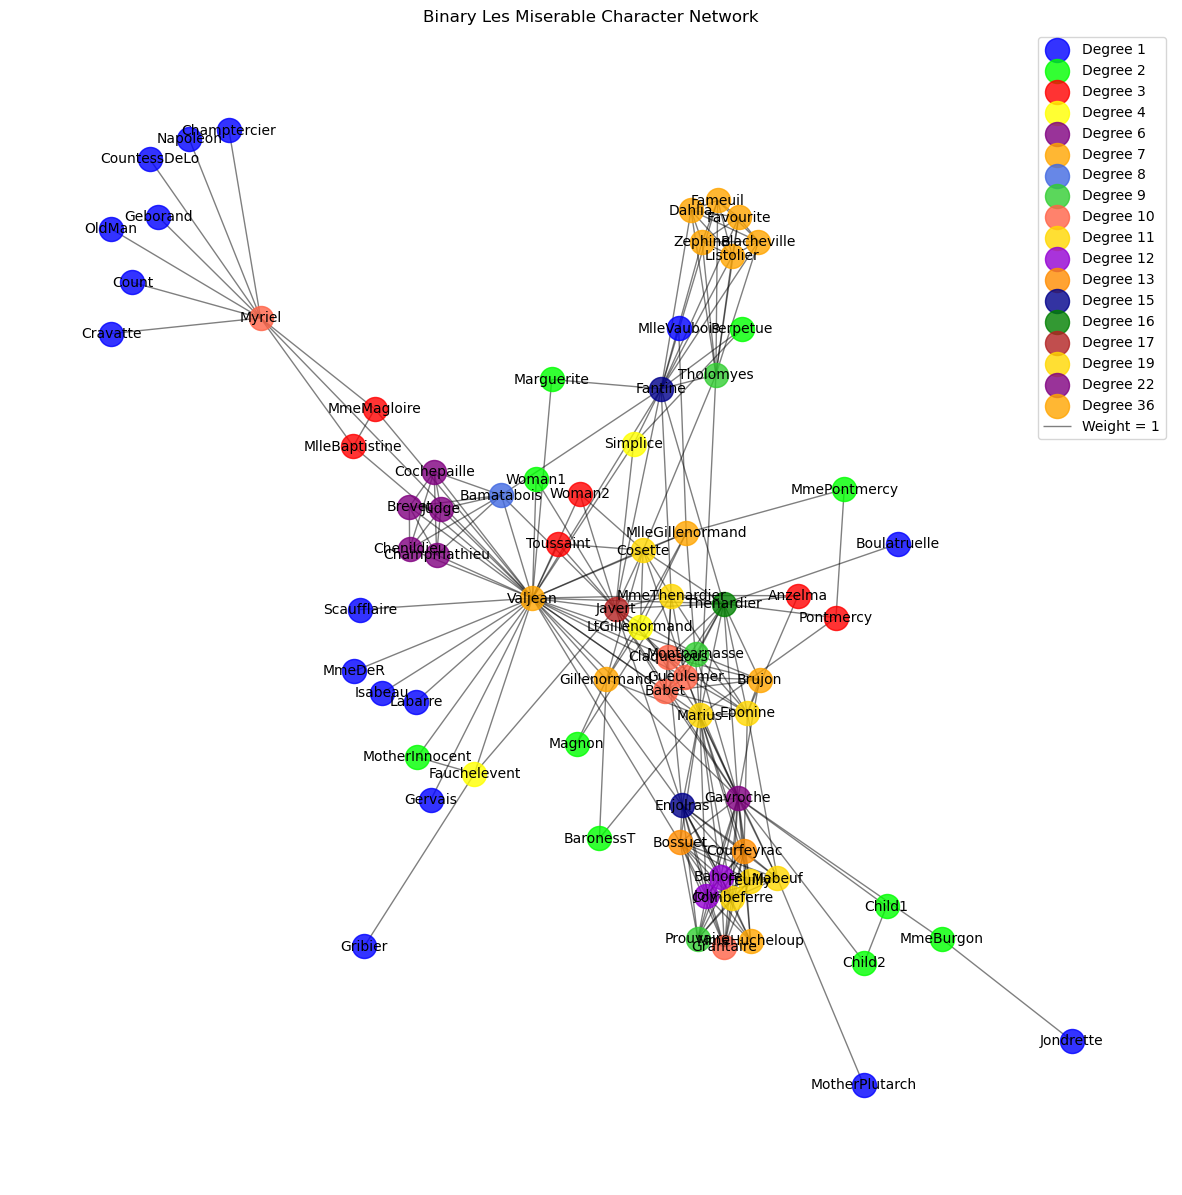

-------------------- Question 2 --------------------
Diameter: 5
Global Clustering Coefficient: 0.5731367499320134
Average Distance: 2.6411483253588517
Smallest Component: 77
Largest Component: 77
-------------------- Question 3 --------------------
Top 3 Degree Centrality: [('Valjean', 0.47368421052631576), ('Gavroche', 0.2894736842105263), ('Marius', 0.25)]
Top 3 Closeness Centrality: [('Valjean', 0.6440677966101694), ('Marius', 0.5314685314685315), ('Thenardier', 0.5170068027210885)]
Top 3 Betweenness Centrality: [('Valjean', 0.5699890527836184), ('Myriel', 0.17684210526315788), ('Gavroche', 0.16511250242584766)]
-------------------- Question 4 --------------------


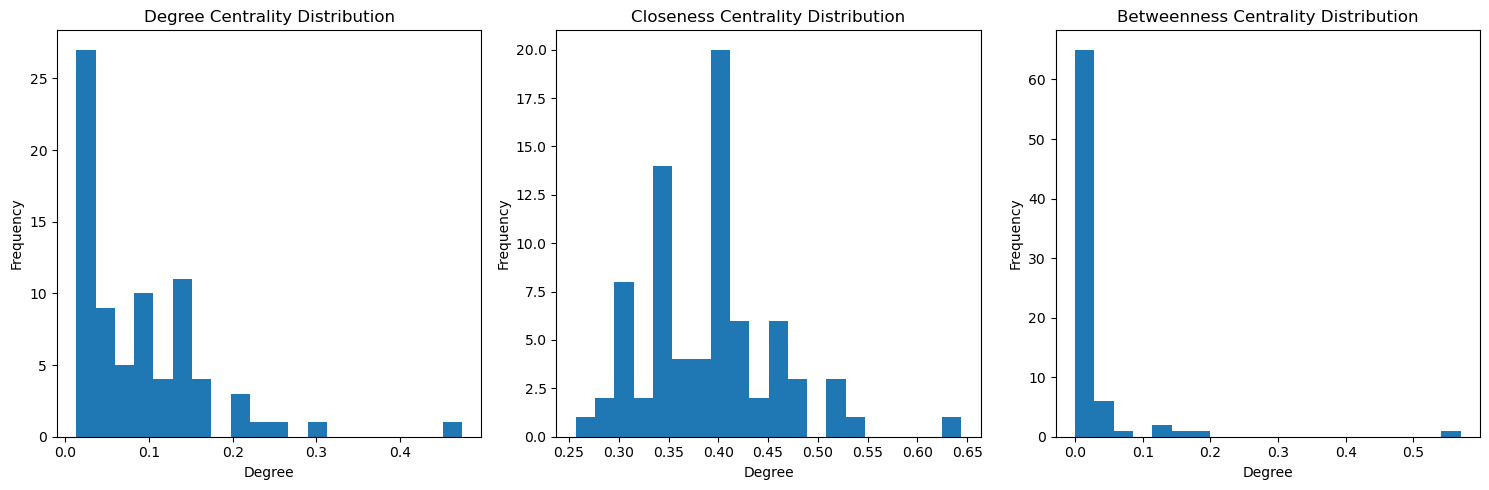

-------------------- Question 5 --------------------
Degree centrality does NOT fit the powerlaw distribution
Closeness centrality does NOT fit the powerlaw distribution
Betweenness centrality does NOT fit the powerlaw distribution
-------------------- Question 6 --------------------


Calculating best minimal value for power law fit
No valid fits found.
Calculating best minimal value for power law fit
No valid fits found.
Calculating best minimal value for power law fit
No valid fits found.
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Degree centrality fits the exponentially truncated powerlaw distribution.
Closeness centrality does NOT fit the exponentially truncated powerlaw distribution
Betweenness centrality does NOT fit the exponentially truncated powerlaw distribution
-------------------- Question 7 --------------------
Communities {1: ['Myriel', 'Napoleon', 'MlleBaptistine', 'MmeMagloire', 'CountessDeLo', 'Geborand', 'Champtercier', 'Cravatte', 'Count', 'OldMan'], 2: ['Tholomyes', 'Listolier', 'Fameuil', 'Blacheville', 'Favourite', 'Dahlia', 'Zephine', 'Fantine', 'Perpetue', 'Simplice'], 3: ['Labarre', 'Valjean', 'Marguerite', 'MmeDeR', 'Isabeau', 'Gervais', 'Fauchelevent', 'Bamatabois', 'Scaufflaire', 'Woman1', 'Judge', 'Champmathieu', 'Brevet', 'Chenildieu', 'Cochepaille', 'Woman2', 'MotherInnocent', 'Gribier', 'Toussaint'], 4: ['Cosette', 'Pontmercy', 'Gillenormand', 'Magnon', 'MlleGillenormand', 'MmePontmercy', 'MlleVaubois', 'LtGillenormand', 'Marius', 'BaronessT'], 5: ['MmeThenardier', 'Thenardier', 'Ja

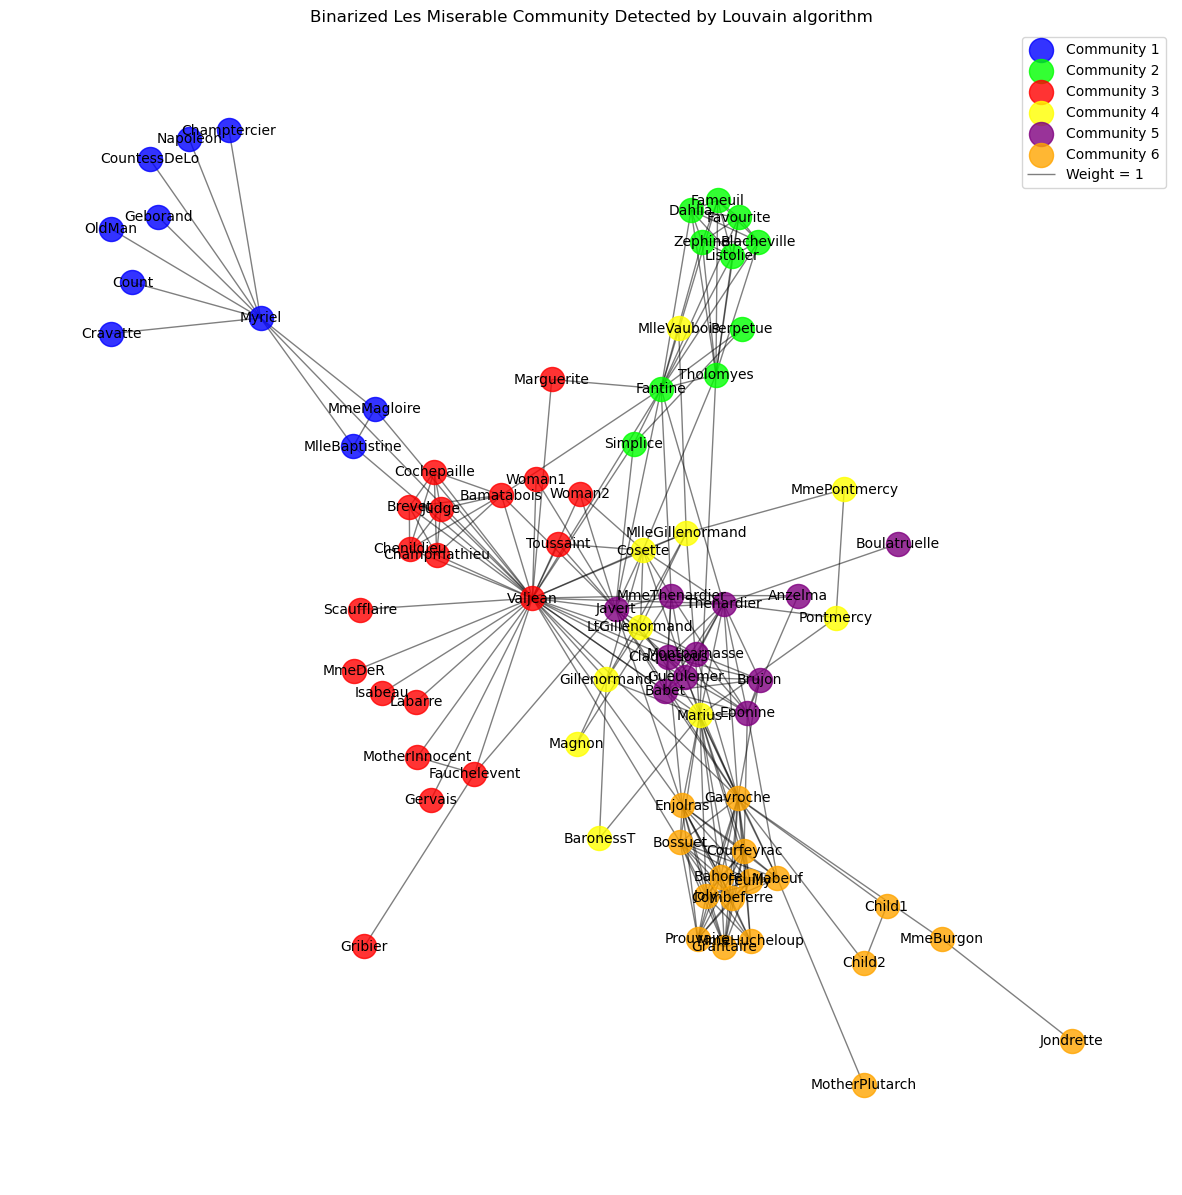

In [9]:
def binarize_graph(graph):
    binary_graph = nx.Graph()
    binary_graph.add_nodes_from(graph.nodes())
    for u, v, data in graph.edges(data=True):
        binary_graph.add_edge(u, v, value=1)
    return binary_graph
binary_lesmis_graph = binarize_graph(lesmis_graph)
adjacency_matrix(binary_lesmis_graph, "binary_adjacency_matrix.txt")
# Question 1
print("-------------------- Question 1 --------------------")
degree_groups2 = classify_nodes(binary_lesmis_graph)
group_visualization(binary_lesmis_graph, degree_groups2, "Binary Les Miserable Character Network", "Degree")
# Question 2
print("-------------------- Question 2 --------------------")
_, _ = calculate_metrics(binary_lesmis_graph)
# Question 3
print("-------------------- Question 3 --------------------")
degree_centrality2, closeness_centrality2, betweenness_centrality2 = calculate_centrality(binary_lesmis_graph)
top3_centrality(degree_centrality2, closeness_centrality2, betweenness_centrality2)
# Question 4
print("-------------------- Question 4 --------------------")
degree_list2, closeness_list2, betweenness_list2 = list_centrality(degree_centrality2, closeness_centrality2, betweenness_centrality2)
centrality_histogram(degree_list2, closeness_list2, betweenness_list2)
# Question 5
print("-------------------- Question 5 --------------------")
binary_degree_p1 = fit_powerlaw(degree_list2)
binary_closeness_p1 = fit_powerlaw(closeness_list2)
binary_betweenness_p1 = fit_powerlaw(betweenness_list2)
quantify_powerlaw(binary_degree_p1, "Degree centrality", "powerlaw")
quantify_powerlaw(binary_closeness_p1, "Closeness centrality", "powerlaw")
quantify_powerlaw(binary_betweenness_p1, "Betweenness centrality", "powerlaw")
# Question 6
print("-------------------- Question 6 --------------------")
binary_degree_p2 = fit_exp_truncated_powerlaw(degree_list2)
binary_closeness_p2 = fit_exp_truncated_powerlaw(closeness_list2)
binary_betweenness_p2 = fit_exp_truncated_powerlaw(betweenness_list2)
quantify_powerlaw(binary_degree_p2, "Degree centrality", "exponentially truncated powerlaw")
quantify_powerlaw(binary_closeness_p2, "Closeness centrality", "exponentially truncated powerlaw")
quantify_powerlaw(binary_betweenness_p2, "Betweenness centrality", "exponentially truncated powerlaw")
# Question 7
print("-------------------- Question 7 --------------------")
louvain_communities2 = louvain_community(binary_lesmis_graph)
group_visualization(binary_lesmis_graph, louvain_communities2, "Binarized Les Miserable Community Detected by Louvain algorithm", "Community")

`From what I know about the novel Les Misérables, after removing the weights of the edges corresponding to the number of coappearances of characters, the communities classified by the Louvain algorithm show a significant reduction in relevance.`

9. We want to approximate the real graph in 1) by a random graph, by looking into the order of magnitude of average clustering coefficient and diameter, comment whether ErdösRenyi random graph or small-world model is more suitable to approximate this real graph. Write a script that  calculates the average clustering coefficient and diameter for various values of probabilities p from 0.1 till 0.9, and identify the value of p that best matches with average clustering coefficient and diameter of the real graph.

In [10]:
probabilities = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
G_diameter, G_avg_cc = calculate_metrics(lesmis_graph, to_print=False)
# Experiment with Erdos Renyi model
er_lowest_difference = float('inf')
er_best_probability = None
er_best_avg_cc_difference = None
er_best_diameter_difference = None
for p in probabilities:
    er_graph = nx.erdos_renyi_graph(len(lesmis_graph), p)
    er_diameter, er_avg_cc = calculate_metrics(er_graph, to_print=False)
    er_diameter_difference = abs(er_diameter - G_diameter)
    er_avg_cc_difference = abs(er_avg_cc - G_avg_cc)
    er_total_difference = er_avg_cc_difference + er_diameter_difference
    if er_total_difference < er_lowest_difference:
        er_best_probability = p
        er_lowest_difference = er_total_difference
        er_best_avg_cc_difference = er_avg_cc_difference
        er_best_diameter_difference = er_diameter_difference
print(f"Best match value: {er_best_probability}")
print(f"Lowest difference: {er_lowest_difference}")
print(f"Best average clustering coefficient difference: {er_best_avg_cc_difference}")
print(f"Best diameter difference: {er_best_diameter_difference}")
# Experiment with Small World model
sw_lowest_difference = float('inf')
sw_best_probability = None
sw_best_avg_cc_difference = None
sw_best_diameter_difference = None
for p in probabilities:
    sw_graph = nx.watts_strogatz_graph(len(lesmis_graph), 4, p)
    sw_diameter, sw_avg_cc = calculate_metrics(sw_graph, to_print=False)
    sw_diameter_difference = abs(sw_diameter - G_diameter)
    sw_avg_cc_difference = abs(sw_avg_cc - G_avg_cc)
    sw_total_difference = sw_avg_cc_difference + sw_diameter_difference
    if sw_total_difference < sw_lowest_difference:
        sw_best_probability = p
        sw_lowest_difference = sw_total_difference
        sw_best_avg_cc_difference = sw_avg_cc_difference
        sw_best_diameter_difference = sw_diameter_difference
print(f"Best match value: {sw_best_probability}")
print(f"Lowest difference: {sw_lowest_difference}")
print(f"Best average clustering coefficient difference: {sw_best_avg_cc_difference}")
print(f"Best diameter difference: {sw_best_diameter_difference}")

Best match value: 0.1
Lowest difference: 10.064333408355838
Best average clustering coefficient difference: 0.06433340835583841
Best diameter difference: 10
Best match value: 0.2
Lowest difference: 6.22549248737206
Best average clustering coefficient difference: 0.2254924873720602
Best diameter difference: 6
